#Spend Analysis & Forecasting
This project focuses on analyzing credit card transactions to uncover spending patterns, forecast future trends, and detect anomalies. Leveraging advanced techniques like Facebook Prophet for time-series forecasting and machine learning models for anomaly detection, the goal is to help financial institutions and businesses enhance budgeting, marketing, and customer experience through predictive analytics.
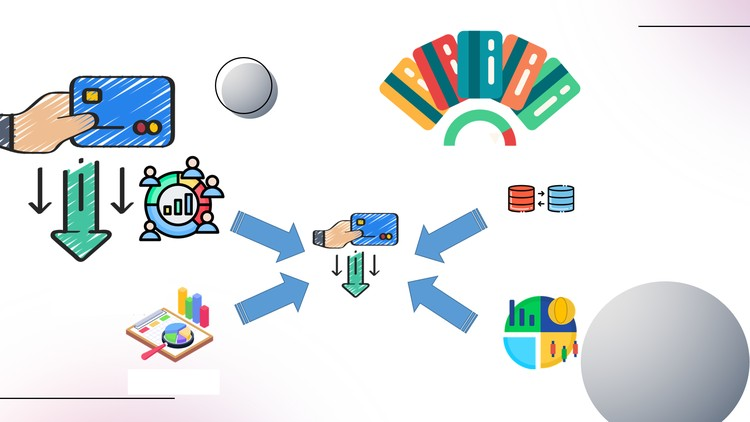
##Key Objectives
###1. Analyze Spending Behavior 🛒
Identify top spending categories and transaction trends.

Detect seasonal patterns, peak spending periods, and hourly trends.

Segment customers based on spending habits (e.g., high spenders vs. low spenders).

Explore correlations between spending behavior and customer demographics (e.g., age, location).

###2. Forecast Future Transactions 📈
Use Facebook Prophet for time-series forecasting to predict future spending.

Incorporate external factors like holidays, paydays, and economic indicators (if available).

Analyze daily, weekly, and monthly spending trends for accurate predictions.

###3. Anomaly Detection 🚨
Identify unusual spending behaviors and potential fraud using statistical methods (e.g., Z-Score, IQR) and machine learning models (e.g., Isolation Forest, DBSCAN).

Differentiate between normal variations and actual anomalies.

Investigate fraud incidence across customer segments and categories.

###4. Advanced Analytics 🔍
Perform association rule mining (e.g., Apriori) to uncover patterns in purchase behavior.

Use clustering techniques (e.g., K-Means, DBSCAN) to group customers based on spending habits.

Explore NLP techniques (if transaction descriptions are available) for enhanced transaction classification.

##Step:1 Load and Inspect Data

####Downloading Packages

In [55]:
!pip install --upgrade mlxtend -q
!pip install --upgrade category-encoders -q
!pip install scikit-learn==1.6.0 -q
!pip install prophet -q
!pip install kaleido -q

####Importing Libraries

In [56]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore
import statsmodels.api as sm
from prophet import Prophet
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

####Download Dataset

In [4]:
# Download latest version
dataset_path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

# Assuming the CSV file is named 'card_transdata.csv' and is within the downloaded directory:
csv_file_path = os.path.join(dataset_path, 'credit_card_transactions.csv')  # Construct the full file path

# Now read the CSV file using the correct path:
df = pd.read_csv(csv_file_path)

100%|██████████| 145M/145M [00:04<00:00, 36.8MB/s]

Extracting files...


####Displaying Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

####Check for Missing values and Duplicates

In [6]:
#check for missing values
print(df.isnull().sum())

# check for duplicates
print(df.duplicated().sum())

# Drop duplicates if necessary
df = df.drop_duplicates()

Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
dtype: int64
0


####Dropping Columns

In [7]:
# Check if both columns exist before dropping
if "Unnamed: 0" in df.columns and "merch_zipcode" in df.columns:
    df.drop(["Unnamed: 0", "merch_zipcode"], axis=1, inplace=True)

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


####Basic Statics

In [8]:
# Summary statistics for the dataset
stats = print(df.describe())

#unique categories in categorical col
print(df.nunique())

             cc_num           amt           zip           lat          long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01 -9.022634e+01   
std    1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00  1.375908e+01   
min    6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01 -1.656723e+02   
25%    1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01 -9.679800e+01   
50%    3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01 -8.747690e+01   
75%    4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01 -8.015800e+01   
max    4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01 -6.795030e+01   

           city_pop     unix_time     merch_lat    merch_long      is_fraud  
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  
mean   8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01  5.788652e-03  
std    3.019564e+05  1.284128e+07  5.109788e+00  1.377

In [9]:
# Check for missing values
print(df.isnull().sum())

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


##Step 2: Exploratory Data Analysis

### 2.1: Beginner Level
1. What are the top spending categories by transaction volume and amount?
2. How does spending vary over time (daily, weekly, monthly trends)?
3. What are the peak spending hours in a day?
4. What is the most common payment method used?
5. Which merchants have the highest transactions?

#### 2.1.1 Top Spending Categories

In [10]:
# Group by 'category' and calculate transaction volume and total amount
category_summary = df.groupby('category').agg(
    transaction_volume=('amt', 'size'),  # Count of transactions
    total_amount=('amt', 'sum')          # Sum of transaction amounts
).reset_index()

# Sort by transaction volume (descending)
top_categories_by_volume = category_summary.sort_values(by='transaction_volume', ascending=False)

# Sort by total amount (descending)
top_categories_by_amount = category_summary.sort_values(by='total_amount', ascending=False)

# Display the top categories
print("Top Categories by Transaction Volume:")
print(top_categories_by_volume.head())

print("\nTop Categories by Total Amount Spent:")
print(top_categories_by_amount.head())

Top Categories by Transaction Volume:
         category  transaction_volume  total_amount
2   gas_transport              131659    8351732.29
4     grocery_pos              123638   14460822.38
6            home              123115    7173928.11
12   shopping_pos              116672    9307993.61
7       kids_pets              113035    6503680.16

Top Categories by Total Amount Spent:
         category  transaction_volume  total_amount
4     grocery_pos              123638   14460822.38
12   shopping_pos              116672    9307993.61
11   shopping_net               97543    8625149.68
2   gas_transport              131659    8351732.29
6            home              123115    7173928.11


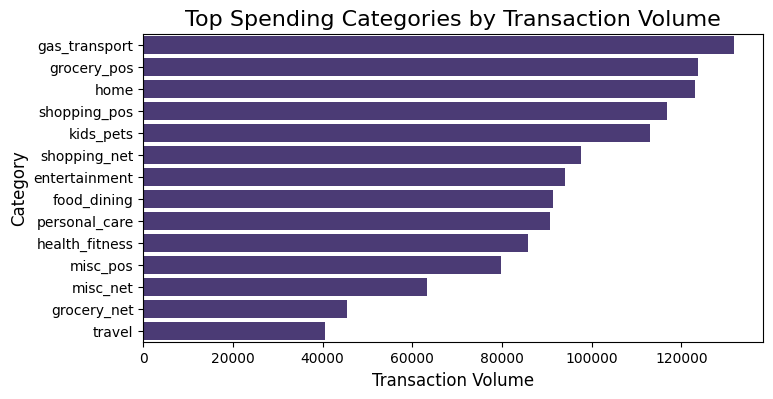

In [11]:
# Set the viridis color palette
sns.set_palette("viridis")

# Plot for Top Categories by Transaction Volume
plt.figure(figsize=(8, 4))
sns.barplot(x='transaction_volume', y='category', data=top_categories_by_volume, orient='h')
plt.title('Top Spending Categories by Transaction Volume', fontsize=16)
plt.xlabel('Transaction Volume', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

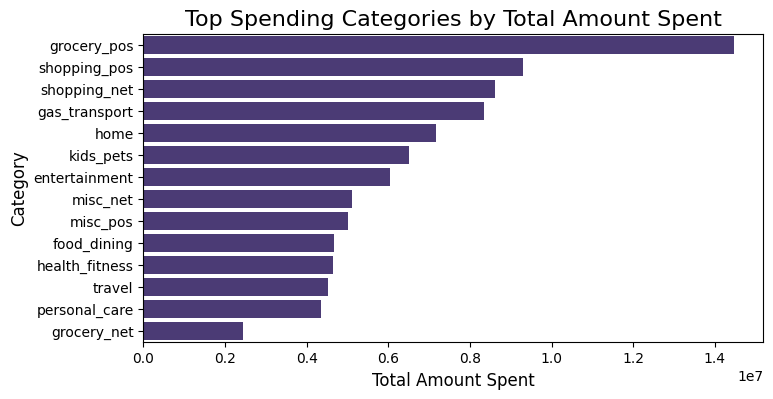

In [12]:
# Plot for Top Categories by Total Amount Spent
plt.figure(figsize=(8, 4))
sns.barplot(x='total_amount', y='category', data=top_categories_by_amount, orient='h')
plt.title('Top Spending Categories by Total Amount Spent', fontsize=16)
plt.xlabel('Total Amount Spent', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

####2.1.2 Spending Variations with Time

In [13]:
# Extract day, week, and month from the datetime column
# Convert 'trans_date_trans_time' to datetime objects
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['day'] = df['trans_date_trans_time'].dt.day
df['week'] = df['trans_date_trans_time'].dt.isocalendar().week  # Extract week number
df['month'] = df['trans_date_trans_time'].dt.month

# Aggregate spending by day, week, and month
daily_spending = df.groupby('day')['amt'].sum().reset_index()
weekly_spending = df.groupby('week')['amt'].sum().reset_index()
monthly_spending = df.groupby('month')['amt'].sum().reset_index()

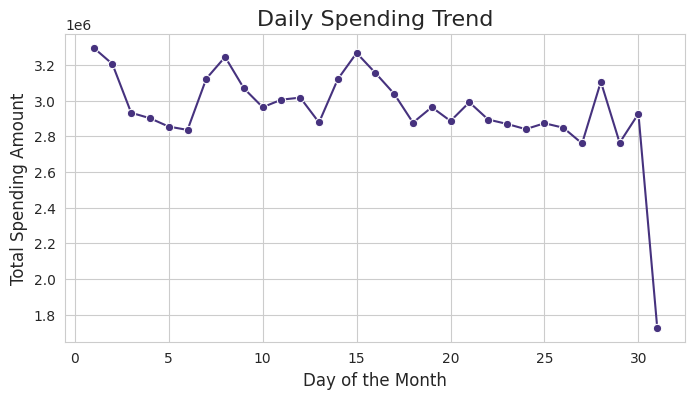

In [14]:
# Set the style and palette
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Plot Daily Spending Trend
plt.figure(figsize=(8, 4))
sns.lineplot(x='day', y='amt', data=daily_spending, marker='o')
plt.title('Daily Spending Trend', fontsize=16)
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Total Spending Amount', fontsize=12)
plt.show()

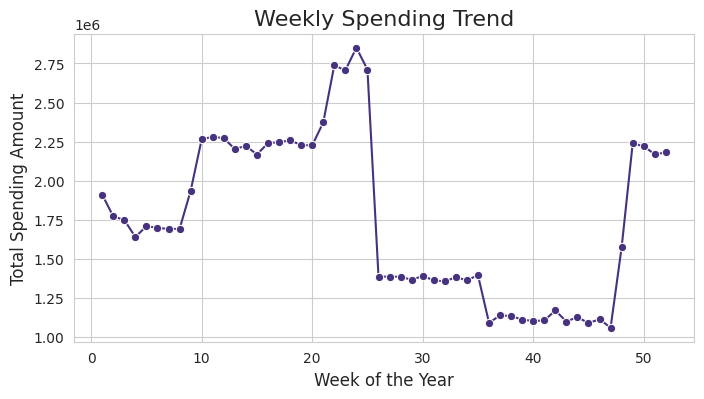

In [15]:
# Plot Weekly Spending Trend
plt.figure(figsize=(8, 4))
sns.lineplot(x='week', y='amt', data=weekly_spending, marker='o')
plt.title('Weekly Spending Trend', fontsize=16)
plt.xlabel('Week of the Year', fontsize=12)
plt.ylabel('Total Spending Amount', fontsize=12)
plt.show()

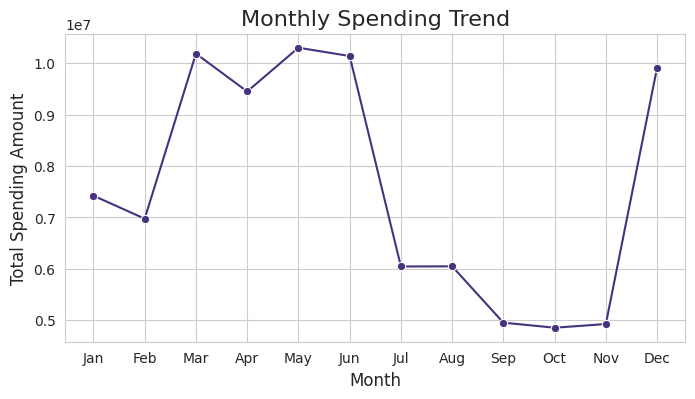

In [16]:
# Plot Monthly Spending Trend
plt.figure(figsize=(8, 4))
sns.lineplot(x='month', y='amt', data=monthly_spending, marker='o')
plt.title('Monthly Spending Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Spending Amount', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

####2.1.3 What Are the Peak Spending Hours in a Day?

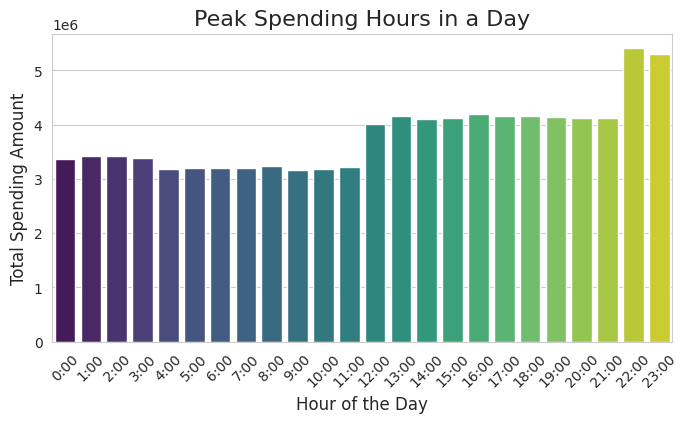

In [17]:
# Convert 'trans_date_trans_time' to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract the hour from the datetime column
df['hour'] = df['trans_date_trans_time'].dt.hour

# Aggregate spending by hour
hourly_spending = df.groupby('hour')['amt'].sum().reset_index()

# Plot Hourly Spending Trend
plt.figure(figsize=(8, 4))
sns.barplot(x='hour', y='amt', data=hourly_spending, palette="viridis")
plt.title('Peak Spending Hours in a Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Total Spending Amount', fontsize=12)
plt.xticks(range(0, 24), [f'{h}:00' for h in range(24)], rotation=45)
plt.show()

####2.1.4 Most Common Payment Method

In [18]:
# Check if all transactions have a valid credit card number
print("Number of unique credit card numbers:", df['cc_num'].nunique())
print("Total number of transactions:", len(df))

Number of unique credit card numbers: 983
Total number of transactions: 1296675


Answer: Since this dataset consists entirely of credit card transactions, all payments are made via credit cards. Therefore, analyzing payment methods is redundant.

####2.1.5 Merchants Having Highest Transactions

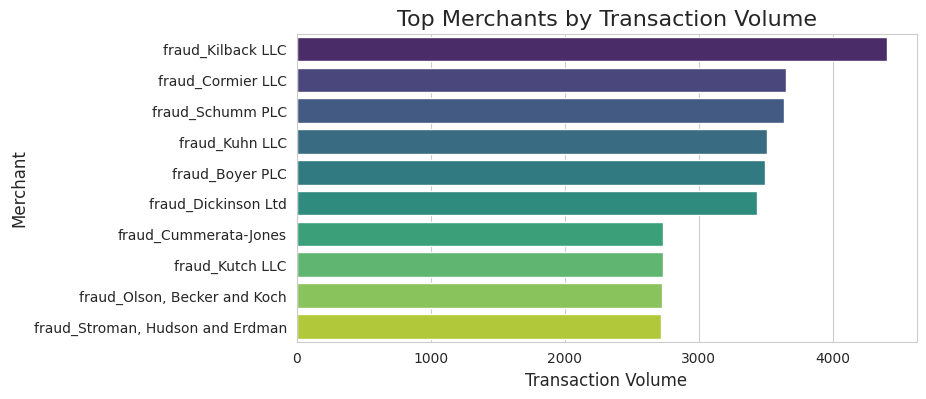

In [19]:
# Group by 'merchant' and calculate transaction volume and total amount
merchant_summary = df.groupby('merchant').agg(
    transaction_volume=('amt', 'size'),  # Count of transactions
    total_amount=('amt', 'sum')          # Sum of transaction amounts
).reset_index()

# Sort by transaction volume (descending)
top_merchants_by_volume = merchant_summary.sort_values(by='transaction_volume', ascending=False).head(10)

# Sort by total amount (descending)
top_merchants_by_amount = merchant_summary.sort_values(by='total_amount', ascending=False).head(10)

# Plot Top Merchants by Transaction Volume
plt.figure(figsize=(8, 4))
sns.barplot(x='transaction_volume', y='merchant', data=top_merchants_by_volume, orient='h', palette = 'viridis')
plt.title('Top Merchants by Transaction Volume', fontsize=16)
plt.xlabel('Transaction Volume', fontsize=12)
plt.ylabel('Merchant', fontsize=12)
plt.show()

###2.2: Intermediate Level
1. Are there seasonal trends in spending across different categories?
2. How do different customer segments (high spenders vs. low spenders) behave?
3. What is the distribution of transaction amounts (e.g., histogram, boxplot analysis)?
4. Are there any correlations between spending behavior and location?
5. How does spending behavior change before and after payday?

####2.2.1 Seasonal Trends in Spending

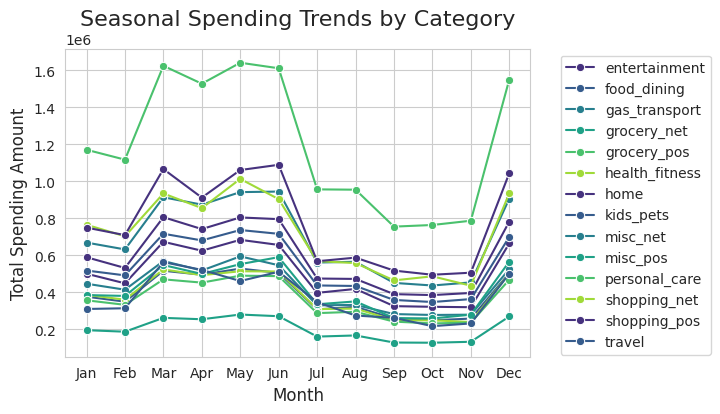

In [20]:
# Convert 'trans_date_trans_time' to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract month and season from the datetime column
df['month'] = df['trans_date_trans_time'].dt.month

# Group by 'category' and 'month' and calculate total spending
seasonal_spending = df.groupby(['category', 'month'])['amt'].sum().reset_index()

# Plot Seasonal Trends by Category
plt.figure(figsize=(6, 4))
for category in seasonal_spending['category'].unique():
    category_data = seasonal_spending[seasonal_spending['category'] == category]
    sns.lineplot(x='month', y='amt', data=category_data, label=category, marker='o')
plt.title('Seasonal Spending Trends by Category', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Spending Amount', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

####2.2.2 Behavior of Customer segments (high spenders vs. low spenders)

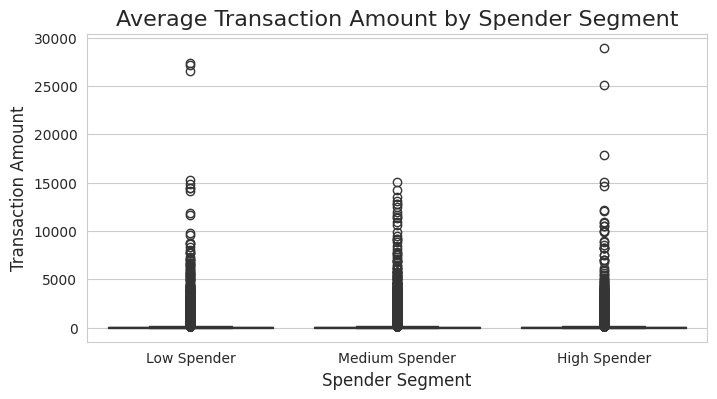

In [21]:
# Calculate total spending for each customer
customer_spending = df.groupby('cc_num')['amt'].sum().reset_index()
customer_spending.rename(columns={'amt': 'total_spending'}, inplace=True)

# Check if 'total_spending' already exists in df
if 'total_spending' in df.columns:
    df = df.drop(columns=['total_spending'])  # Drop the existing column

# Now, merge total spending back into the main dataframe without conflict
df = df.merge(customer_spending, on='cc_num')

# Now you can access 'total_spending' to create the 'spender_segment' column
df['spender_segment'] = pd.qcut(df['total_spending'], q=3, labels=['Low Spender', 'Medium Spender', 'High Spender'])
# Compare Average Transaction Amount by Segment
plt.figure(figsize=(8, 4))
sns.boxplot(x='spender_segment', y='amt', data=df)
plt.title('Average Transaction Amount by Spender Segment', fontsize=16)
plt.xlabel('Spender Segment', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)
plt.show()

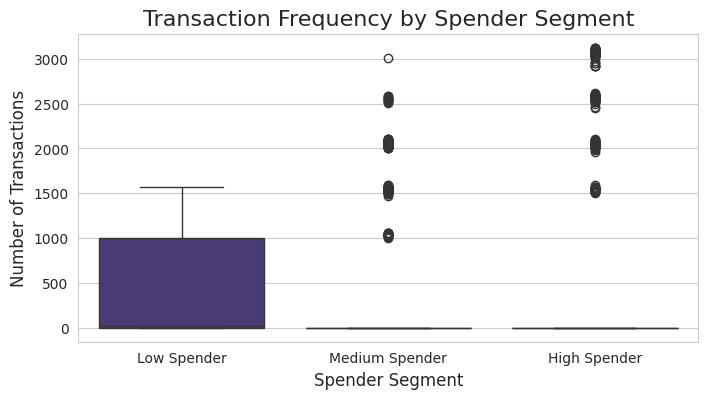

In [22]:
# Compare Transaction Frequency by Segment
transaction_frequency = df.groupby(['cc_num', 'spender_segment']).size().reset_index(name='transaction_count')
plt.figure(figsize=(8, 4))
sns.boxplot(x='spender_segment', y='transaction_count', data=transaction_frequency)
plt.title('Transaction Frequency by Spender Segment', fontsize=16)
plt.xlabel('Spender Segment', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.show()

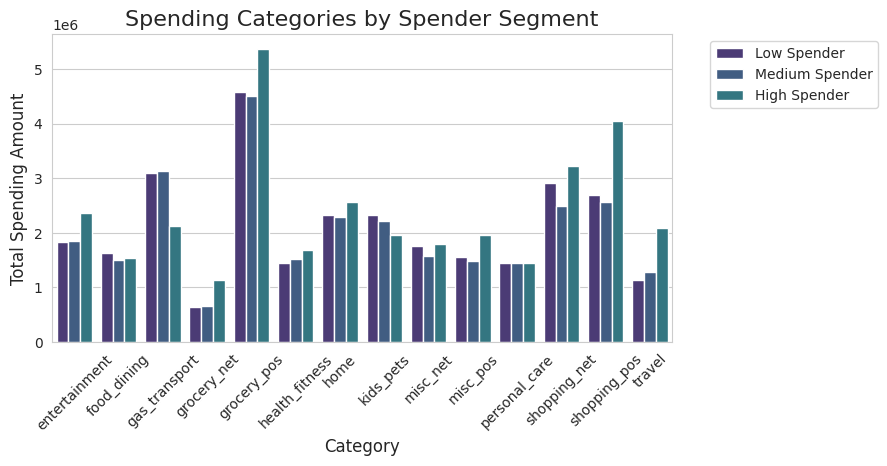

In [23]:
# Compare Spending Categories by Segment
category_spending = df.groupby(['spender_segment', 'category'])['amt'].sum().reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='amt', hue='spender_segment', data=category_spending)
plt.title('Spending Categories by Spender Segment', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Spending Amount', fontsize=12)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

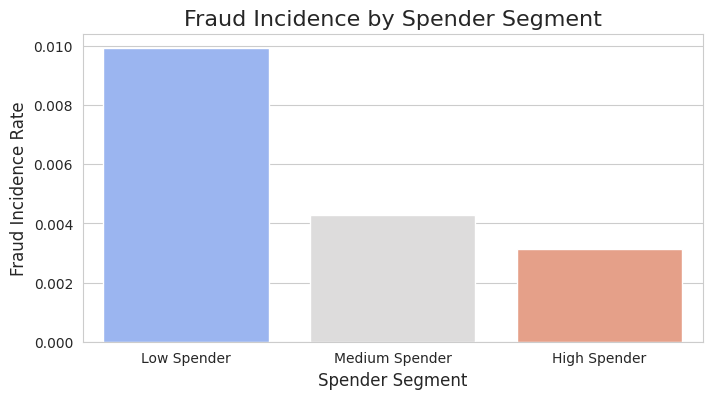

In [24]:
# Compare Fraud Incidence by Segment
fraud_incidence = df.groupby('spender_segment')['is_fraud'].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='spender_segment', y='is_fraud', data=fraud_incidence, palette = 'coolwarm')
plt.title('Fraud Incidence by Spender Segment', fontsize=16)
plt.xlabel('Spender Segment', fontsize=12)
plt.ylabel('Fraud Incidence Rate', fontsize=12)
plt.show()

####2.2.3 Distribution of Transaction Amounts

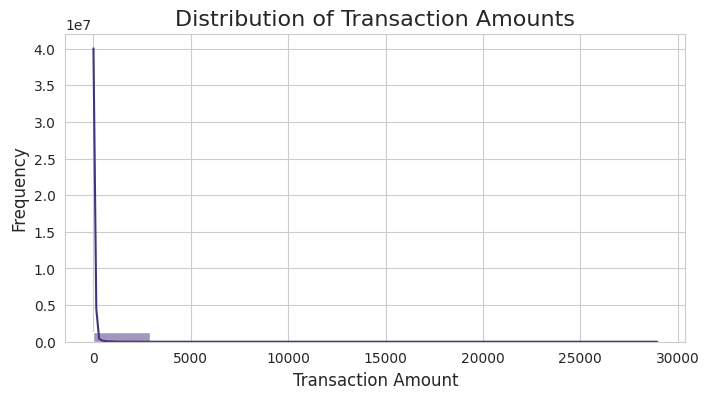

In [25]:
# Plot Histogram of Transaction Amounts
plt.figure(figsize=(8, 4))
sns.histplot(df['amt'], bins=10, kde=True)
plt.title('Distribution of Transaction Amounts', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

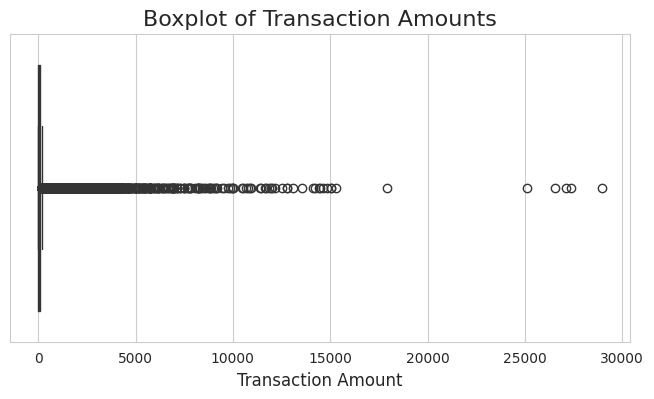

In [26]:
# Plot Boxplot of Transaction Amounts
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['amt'])
plt.title('Boxplot of Transaction Amounts', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=12)
plt.show()

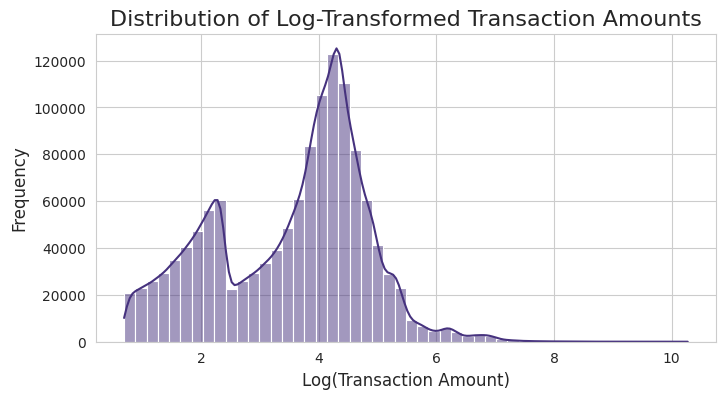

In [27]:
# Log Transformation for Highly Skewed Data
df['log_amt'] = np.log1p(df['amt'])  # Apply log transformation

# Plot Histogram of Log-Transformed Transaction Amounts
plt.figure(figsize=(8, 4))
sns.histplot(df['log_amt'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Transaction Amounts', fontsize=16)
plt.xlabel('Log(Transaction Amount)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

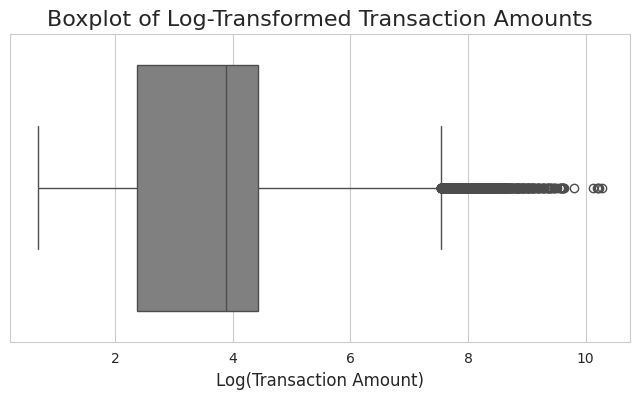

In [28]:
# Plot Boxplot of Log-Transformed Transaction Amounts with Grey Color
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['log_amt'], color='grey')
plt.title('Boxplot of Log-Transformed Transaction Amounts', fontsize=16)
plt.xlabel('Log(Transaction Amount)', fontsize=12)
plt.show()

####2.2.4 Correlations between spending behavior and location

In [29]:
# Aggregate total spending by city
city_spending = df.groupby('city')['amt'].sum().reset_index()

# Aggregate total spending by state
state_spending = df.groupby('state')['amt'].sum().reset_index()

# Sort by total spending
city_spending = city_spending.sort_values(by='amt', ascending=False).head(10)
state_spending = state_spending.sort_values(by='amt', ascending=False).head(10)

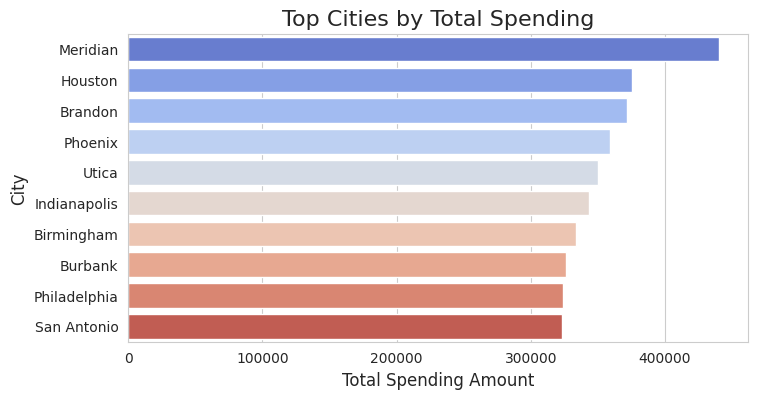

In [30]:
# Plot Top Cities by Total Spending
plt.figure(figsize=(8, 4))
sns.barplot(x='amt', y='city', data=city_spending, orient='h', palette = 'coolwarm')
plt.title('Top Cities by Total Spending', fontsize=16)
plt.xlabel('Total Spending Amount', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.show()

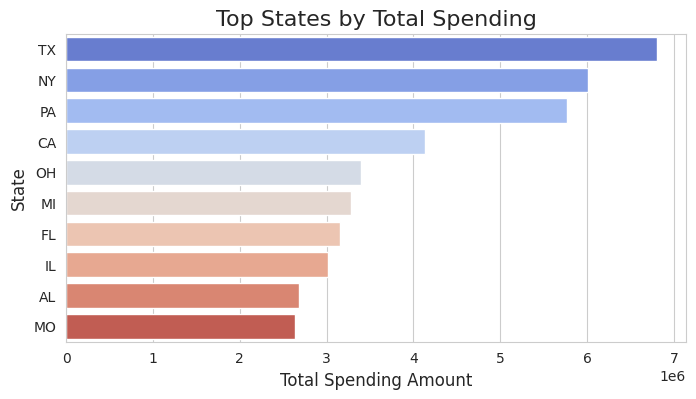

In [31]:
# Plot Top States by Total Spending
plt.figure(figsize=(8, 4))
sns.barplot(x='amt', y='state', data=state_spending, orient='h', palette = 'coolwarm')
plt.title('Top States by Total Spending', fontsize=16)
plt.xlabel('Total Spending Amount', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.show()

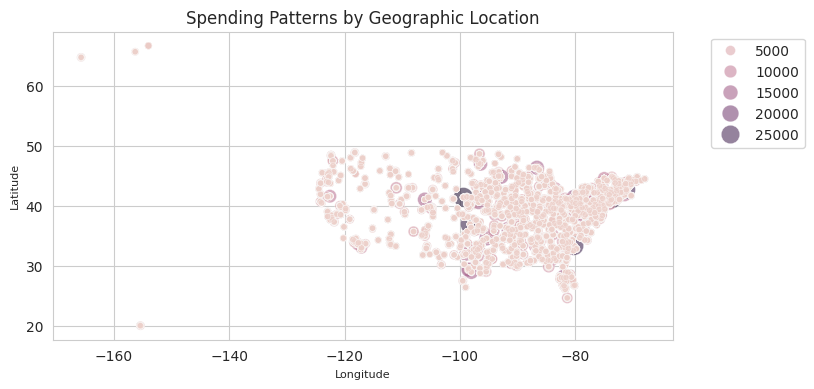

In [32]:
# Scatter plot of spending by location
plt.figure(figsize=(8, 4))
sns.scatterplot(x='long', y='lat', size='amt', hue='amt', data=df, sizes=(20, 200), alpha=0.6)
plt.title('Spending Patterns by Geographic Location', fontsize=12)
plt.xlabel('Longitude', fontsize=8)
plt.ylabel('Latitude', fontsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Correlation between Transaction Amount and City Population:
               amt  city_pop
amt       1.000000  0.005818
city_pop  0.005818  1.000000


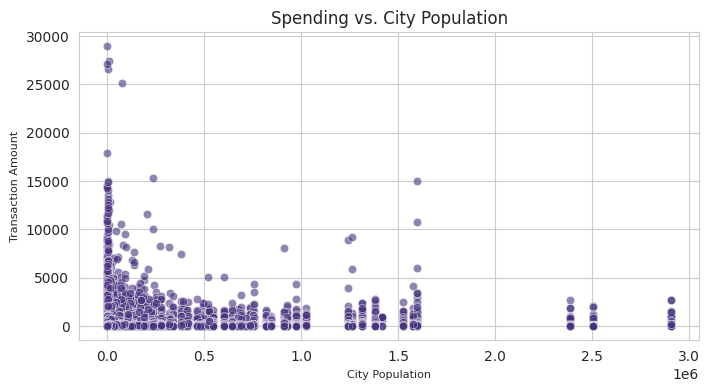

In [33]:
# Calculate correlation between spending and city population
correlation = df[['amt', 'city_pop']].corr()
print("Correlation between Transaction Amount and City Population:")
print(correlation)

# Scatter plot of spending vs. city population
plt.figure(figsize=(8, 4))
sns.scatterplot(x='city_pop', y='amt', data=df, alpha=0.6)
plt.title('Spending vs. City Population', fontsize=12)
plt.xlabel('City Population', fontsize=8)
plt.ylabel('Transaction Amount', fontsize=8)
plt.show()

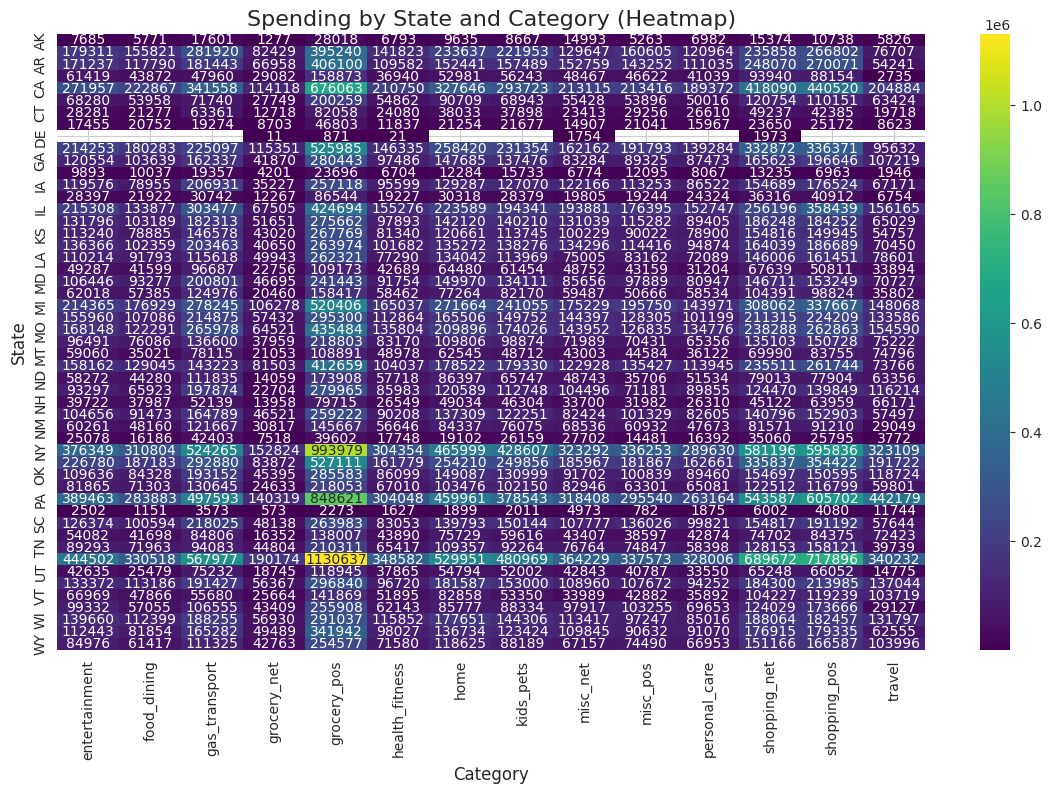

In [34]:
# Heatmap of spending by state and category
state_category_spending = df.groupby(['state', 'category'])['amt'].sum().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(state_category_spending, cmap="viridis", annot=True, fmt=".0f")
plt.title('Spending by State and Category (Heatmap)', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.show()

####2.2.5 Change in spending behavior beforeand after payday

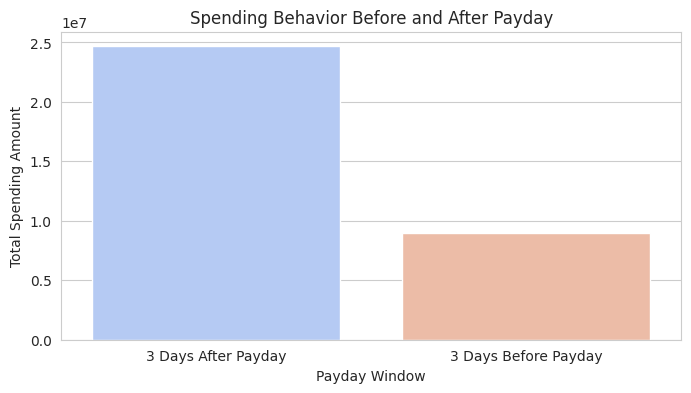

In [35]:
# Convert 'trans_date_trans_time' to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract day of the month
df['day_of_month'] = df['trans_date_trans_time'].dt.day

# Assume paydays are on the 1st and 15th of each month
paydays = [1, 15]

# Define time windows around paydays (3 days before and after)
window = 3

# Create a column to indicate if a transaction is before or after payday
df['payday_window'] = None

for payday in paydays:
    df.loc[(df['day_of_month'] >= payday - window) & (df['day_of_month'] < payday), 'payday_window'] = f'{window} Days Before Payday'
    df.loc[(df['day_of_month'] >= payday) & (df['day_of_month'] <= payday + window), 'payday_window'] = f'{window} Days After Payday'

# Filter out transactions outside the payday windows
payday_spending = df[df['payday_window'].notnull()]

# Aggregate spending by payday window
payday_summary = payday_spending.groupby('payday_window')['amt'].sum().reset_index()

# Plot Spending Before and After Payday
plt.figure(figsize=(8, 4))
sns.barplot(x='payday_window', y='amt', data=payday_summary, palette = 'coolwarm')
plt.title('Spending Behavior Before and After Payday', fontsize=12)
plt.xlabel('Payday Window', fontsize=10)
plt.ylabel('Total Spending Amount', fontsize=10)
plt.show()

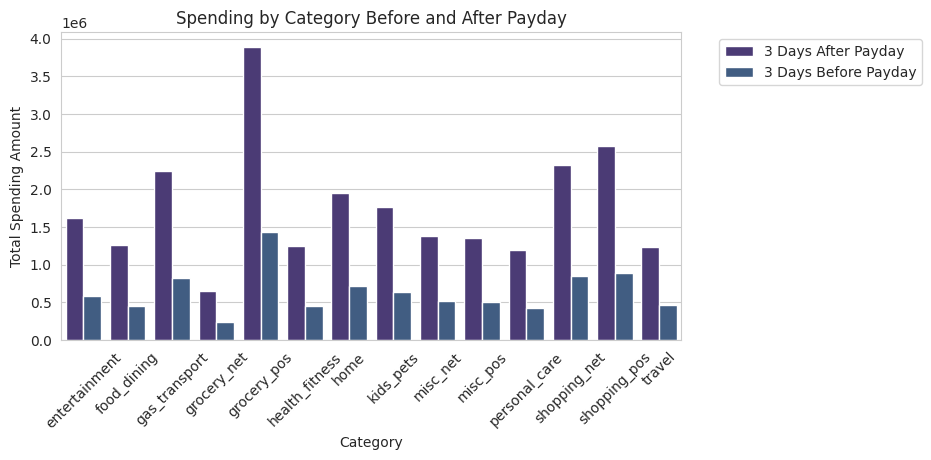

In [36]:
# compare by category
category_payday_spending = payday_spending.groupby(['payday_window', 'category'])['amt'].sum().reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='amt', hue='payday_window', data=category_payday_spending)
plt.title('Spending by Category Before and After Payday', fontsize=12)
plt.xlabel('Category', fontsize=10)
plt.ylabel('Total Spending Amount', fontsize=10)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

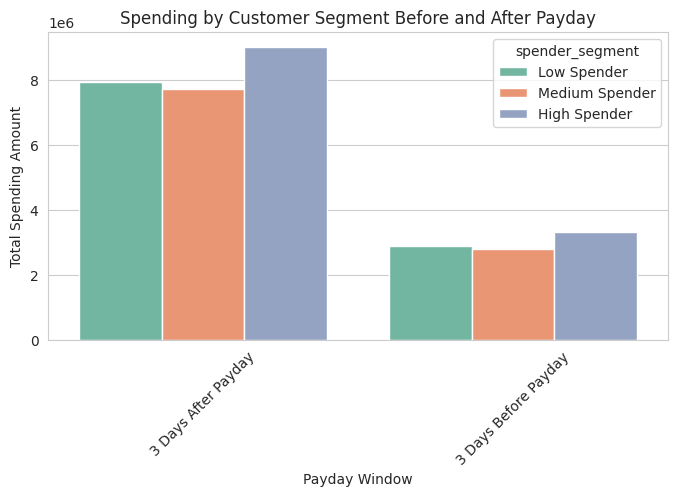

In [37]:
#Customer segment comparison
customer_segment_payday_spending = payday_spending.groupby(['payday_window', 'spender_segment'])['amt'].sum().reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='payday_window', y='amt', hue='spender_segment', data=customer_segment_payday_spending, palette='Set2')
plt.xticks(rotation=45)
plt.title('Spending by Customer Segment Before and After Payday', fontsize=12)
plt.xlabel('Payday Window', fontsize=10)
plt.ylabel('Total Spending Amount', fontsize=10)
plt.show()

###2.3 Advance Level
1. Can we detect outliers in spending behavior using anomaly detection?
2. Are there clusters of customers based on spending habits? (Use K-Means, DBSCAN)
3. Can we use association rule mining (Apriori, FP-Growth) to find patterns in
purchases?
4. How does spending behavior correlate with economic factors (e.g., inflation, interest
rates)?
5. Can we use NLP on transaction descriptions to classify transactions more effectively?

####2.3.1 Outliers Detection

In [38]:
# Calculate Z-Score for transaction amounts
df['z_score'] = zscore(df['amt'])

# Identify outliers using Z-Score (e.g., |Z| > 3)
z_outliers = df[np.abs(df['z_score']) > 3]

# Calculate IQR for transaction amounts
Q1 = df['amt'].quantile(0.25)
Q3 = df['amt'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using IQR (e.g., outside 1.5 * IQR)
iqr_outliers = df[(df['amt'] < (Q1 - 1.5 * IQR)) | (df['amt'] > (Q3 + 1.5 * IQR))]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


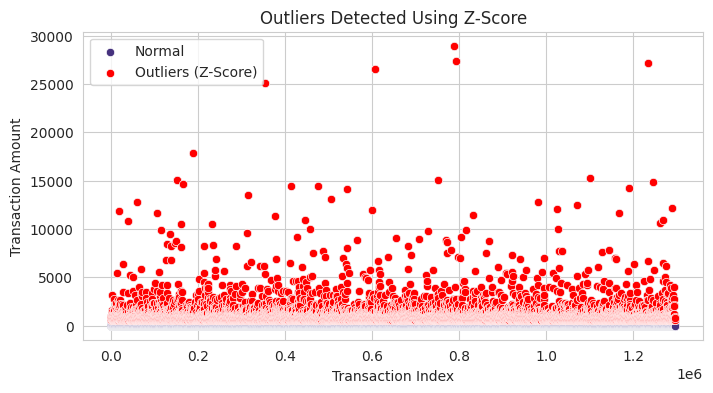

In [39]:
# Plot Z-Score Outliers
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df.index, y='amt', data=df, label='Normal')
sns.scatterplot(x=z_outliers.index, y='amt', data=z_outliers, color='red', label='Outliers (Z-Score)')
plt.title('Outliers Detected Using Z-Score', fontsize=12)
plt.xlabel('Transaction Index', fontsize=10)
plt.ylabel('Transaction Amount', fontsize=10)
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


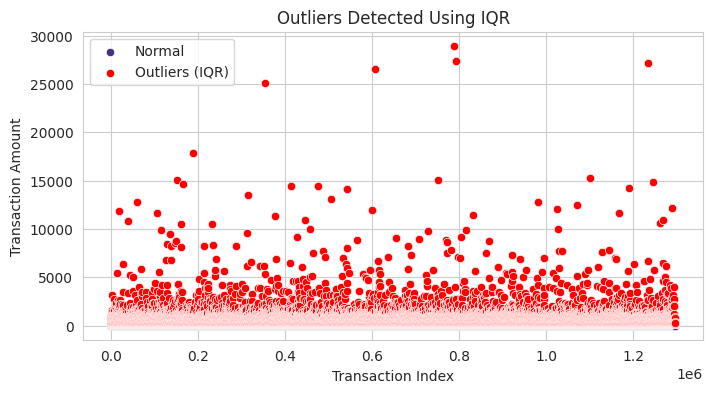

In [40]:
# Plot IQR Outliers
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df.index, y='amt', data=df, label='Normal')
sns.scatterplot(x=iqr_outliers.index, y='amt', data=iqr_outliers, color='red', label='Outliers (IQR)')
plt.title('Outliers Detected Using IQR', fontsize=12)
plt.xlabel('Transaction Index', fontsize=10)
plt.ylabel('Transaction Amount', fontsize=10)
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


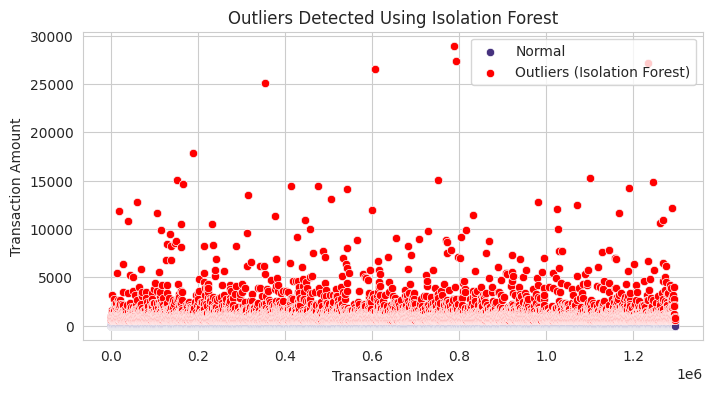

In [41]:
# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Adjust contamination based on expected outlier proportion
df['anomaly_score'] = iso_forest.fit_predict(df[['amt']])

# Identify outliers (anomaly_score = -1)
iso_outliers = df[df['anomaly_score'] == -1]

# Plot Isolation Forest Outliers
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df.index, y='amt', data=df, label='Normal')
sns.scatterplot(x=iso_outliers.index, y='amt', data=iso_outliers, color='red', label='Outliers (Isolation Forest)')
plt.title('Outliers Detected Using Isolation Forest', fontsize=12)
plt.xlabel('Transaction Index', fontsize=10)
plt.ylabel('Transaction Amount', fontsize=10)
plt.legend()
plt.show()

In [42]:
#Fraud Outliers
fraud_outliers = df[(df['anomaly_score'] == -1) & (df['is_fraud'] == 1)]
print("Fraudulent Outliers:")
print(fraud_outliers)

Fraudulent Outliers:
        trans_date_trans_time            cc_num  \
2937      2019-01-02 13:38:08     4613314721966   
3527      2019-01-02 23:52:08     4613314721966   
4383      2019-01-03 18:07:01  4922710831011201   
4644      2019-01-03 22:09:00  4922710831011201   
4654      2019-01-03 22:21:15     4613314721966   
...                       ...               ...   
1295194   2020-06-20 23:04:36  4986925034905735   
1295255   2020-06-20 23:29:52  3560725013359375   
1295274   2020-06-20 23:40:26  6564459919350820   
1295399   2020-06-21 01:00:08  3524574586339330   
1295491   2020-06-21 01:53:35  3524574586339330   

                                       merchant      category      amt  \
2937                         fraud_Medhurst PLC  shopping_net   844.80   
3527                        fraud_Ruecker Group      misc_net   843.91   
4383                        fraud_Pouros-Conroy  shopping_pos   711.66   
4644     fraud_Johnson, Runolfsdottir and Mayer      misc_net   707.50

In [43]:
#category outliers
category_outliers = df[df['anomaly_score'] == -1].groupby('category').size().reset_index(name='outlier_count')
print("Outliers by Category:")
print(category_outliers)

Outliers by Category:
         category  outlier_count
0   entertainment             96
1     food_dining              9
2  health_fitness              1
3            home              1
4       kids_pets              3
5        misc_net           2065
6        misc_pos           1209
7    shopping_net           4066
8    shopping_pos           3915
9          travel           1263


####2.3.2 Clusters of Customers

In [44]:
#Feature Engineering

# Calculate total spending, average transaction amount, and transaction count for each customer
customer_summary = df.groupby('cc_num').agg(
    total_spending=('amt', 'sum'),
    avg_amt=('amt', 'mean'),
    transaction_count=('amt', 'size')
).reset_index()

# Drop existing columns from df if they exist
cols_to_drop = ['total_spending', 'avg_amt', 'transaction_count']
df = df.drop(columns=cols_to_drop, errors='ignore')

# Merge with the original dataframe using suffixes to avoid conflicts
df = df.merge(customer_summary, on='cc_num', suffixes=('', '_y'))

In [45]:
#Data Preprocessing

# Select features for clustering
features = customer_summary[['total_spending', 'avg_amt', 'transaction_count']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

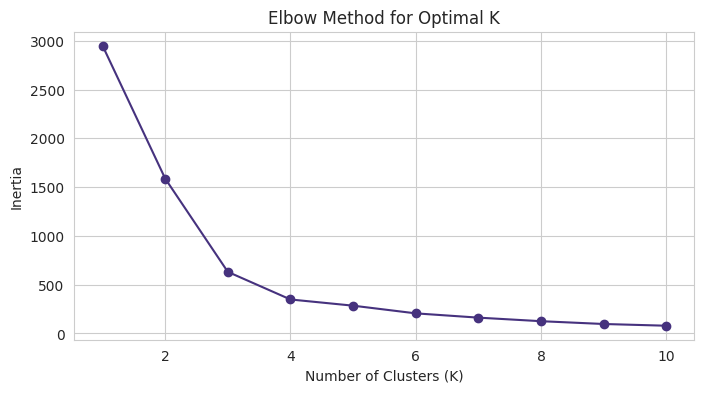

In [46]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K', fontsize=12)
plt.xlabel('Number of Clusters (K)', fontsize=10)
plt.ylabel('Inertia', fontsize=10)
plt.show()

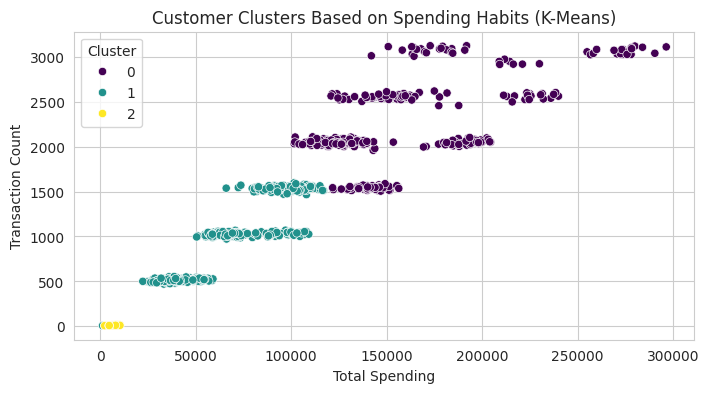

In [47]:
# Apply K-Means with the optimal number of clusters (e.g., K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_summary['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(8, 4))
sns.scatterplot(x='total_spending', y='transaction_count', hue='cluster', data=customer_summary, palette='viridis')
plt.title('Customer Clusters Based on Spending Habits (K-Means)', fontsize=12)
plt.xlabel('Total Spending', fontsize=10)
plt.ylabel('Transaction Count', fontsize=10)
plt.legend(title='Cluster')
plt.show()

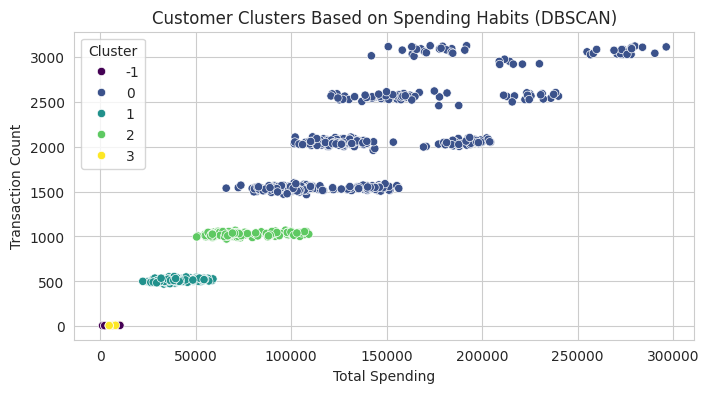

In [48]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust eps and min_samples based on data
customer_summary['cluster'] = dbscan.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(8, 4))
sns.scatterplot(x='total_spending', y='transaction_count', hue='cluster', data=customer_summary, palette='viridis')
plt.title('Customer Clusters Based on Spending Habits (DBSCAN)', fontsize=12)
plt.xlabel('Total Spending', fontsize=10)
plt.ylabel('Transaction Count', fontsize=10)
plt.legend(title='Cluster')
plt.show()

In [49]:
#Cluster Profiling
cluster_profile = customer_summary.groupby('cluster').agg(
    avg_total_spending=('total_spending', 'mean'),
    avg_transaction_count=('transaction_count', 'mean'),
    size=('cc_num', 'size')
).reset_index()
print("Cluster Profiles:")
print(cluster_profile)

Cluster Profiles:
   cluster  avg_total_spending  avg_transaction_count  size
0       -1         5018.921667               8.333333     6
1        0       139741.789151            2013.757764   483
2        1        38247.106561             514.728507   221
3        2        72706.436667            1027.127451   204
4        3         5975.472174              10.014493    69


####2.3.3 Association Rule Mining

In [50]:
# Group transactions by 'cc_num' (customer) and aggregate categories
transactions = df.groupby('cc_num')['category'].apply(list).reset_index(name='items')

# Convert the list of items into a transaction format
transaction_list = transactions['items'].tolist()

In [51]:
# Apriori Algorithm
# Convert transactions into a one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets using Apriori
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)  # Adjust min_support as needed

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the rules
print("Association Rules:")
print(rules)

Association Rules:
              antecedents                                        consequents  \
0         (entertainment)                                      (food_dining)   
1           (food_dining)                                    (entertainment)   
2         (gas_transport)                                    (entertainment)   
3         (entertainment)                                    (gas_transport)   
4         (entertainment)                                      (grocery_net)   
...                   ...                                                ...   
4750183    (shopping_pos)  (shopping_net, gas_transport, travel, kids_pet...   
4750184   (personal_care)  (shopping_net, gas_transport, travel, kids_pet...   
4750185  (health_fitness)  (shopping_net, gas_transport, travel, kids_pet...   
4750186     (food_dining)  (shopping_net, gas_transport, travel, kids_pet...   
4750187     (grocery_net)  (shopping_net, gas_transport, travel, kids_pet...   

         antecedent 

####2.3.4 Coorelation of spending behavior with economic factors

In this section, we aimed to explore the relationship between spending behavior and economic factors like inflation and interest rates. However, our dataset lacks external economic indicators such as inflation rates, interest rates, or GDP growth, making it impossible to directly correlate macroeconomic conditions with individual spending patterns. Instead, we focused on internal factors like customer age, spending segments, and payday categories to analyze their impact on transaction behavior. While these insights shed light on individual spending habits, they do not capture broader economic trends. A more comprehensive analysis would require integrating external financial data from sources like government reports or financial institutions, which is beyond the scope of our current dataset. Therefore, we are omitting this analysis.

####2.3.5 NLP to Classify Transaction Description

Natural Language Processing (NLP) techniques are typically applied to classify transactions using text descriptions, but our dataset lacks a transaction description field, making NLP-based classification unfeasible. Without textual data, methods like TF-IDF, Word2Vec, or BERT cannot be utilized. Instead, we relied on structured fields such as merchant names, transaction categories, and spending segments to classify transactions, employing clustering and machine learning techniques to identify patterns. While this approach provides insights into spending behavior, it does not fully leverage NLP due to the absence of descriptive text. Consequently, we are unable to incorporate NLP methods and skip this analysis.

## Step:3 Machine Learning Model (Facebook Prophet)


### 3.1 Prepare Data

In [ ]:
from scipy.stats import skew
#Calculate skewness before transformation:
original_skewness = skew(df["amt"])
print("Skewness before log transformation:", original_skewness)

# Calculate IQR (Interquartile Range)
Q1 = df["amt"].quantile(0.25)
Q3 = df["amt"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#  Cap Outliers (Winsorization) - Uncomment if you prefer capping
df["amt"] = np.where(df["amt"] < lower_bound, lower_bound, df["amt"])
df["amt"] = np.where(df["amt"] > upper_bound, upper_bound, df["amt"])

# Recalculate skewness after handling outliers
cleaned_skewness = skew(df["amt"])
print("Skewness after handling outliers:", cleaned_skewness)

#Apply log transformation permanently:
df["amt"] = np.log1p(df["amt"])  # log(amt + 1) to handle zero values

#Calculate skewness after transformation:
transformed_skewness = skew(df["amt"])
print("Skewness after log transformation:", transformed_skewness)


Skewness before log transformation: -1.2761550755616993
Skewness after handling outliers: -1.2722795349707607
Skewness after log transformation: -1.2764459694710188


In [ ]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,total_spent,transaction_count,transaction_date,transaction_hour,spending_segment,day_of_month,payday_category,z_score,outlier_z,outlier_if
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,0.115953,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,177233.44,2028,2019-01-01,0,High Spender,1,After Payday,1.390731,False,False
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,0.122649,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,163466.44,3030,2019-01-01,0,High Spender,1,After Payday,0.956081,False,False


In [ ]:
# Aggregate transactions **category-wise** by day
df_prophet = df.groupby("transaction_date")["amt"].sum().reset_index()

# Rename columns for Prophet
df_prophet.columns = ["ds",  "y"]  # 'ds' = date, 'y' = target variabl

df_prophet.head()

,ds,y
0,2019-01-01,289.883668
1,2019-01-02,134.306958
2,2019-01-03,148.638140
3,2019-01-04,177.373611
4,2019-01-05,169.471793


### 3.2 Train the Prophet Model

In [ ]:
# Initialize the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)  # Add monthly seasonality

# Fit the model
model.fit(df_prophet)

# Create a future dataframe (e.g., forecast next 30 days)
future = model.make_future_dataframe(periods=30,freq="D")

# Make predictions
forecast = model.predict(future)

# Display predictions
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

09:09:58 - cmdstanpy - INFO - Chain [1] start processing
09:10:00 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
562,2020-07-17,300.853388,230.860770,375.167490
563,2020-07-18,370.383418,291.734868,439.895352
564,2020-07-19,432.724625,361.872026,506.661483
565,2020-07-20,439.071526,369.537757,511.435313
566,2020-07-21,289.874572,222.086370,362.861320


In [ ]:
#import pickle

# Save the trained model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)


### 3.3 Visualize Forecast

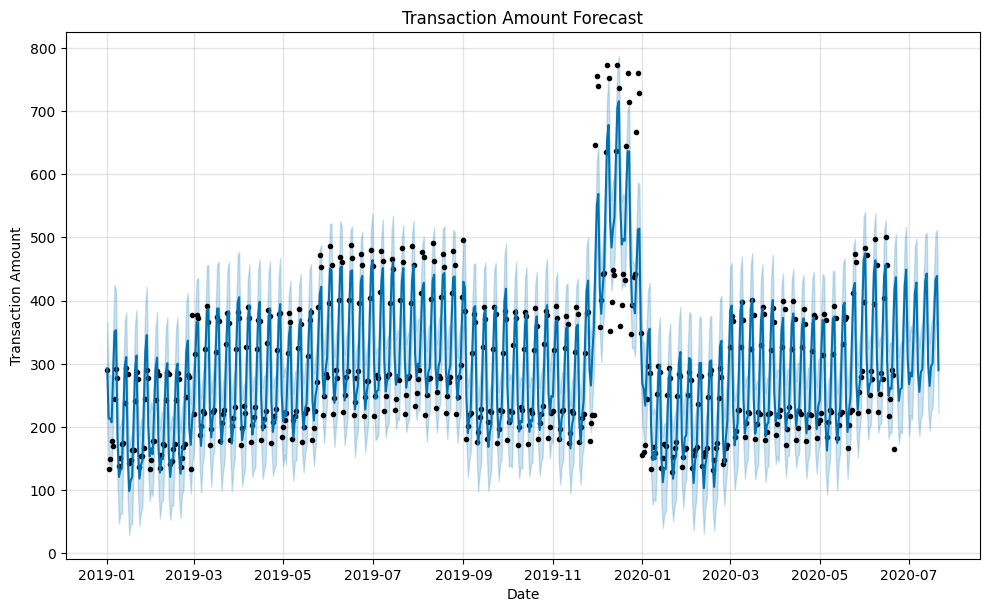

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.title("Transaction Amount Forecast")
plt.xlabel("Date")
plt.ylabel("Transaction Amount")

# Save the figure
plt.savefig("transaction_forecast.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


### 3.4 Visualizing Trend & Seasonality Components
Prophet allows us to break down the forecast into its components:

- Trend (overall increase or decrease in spending)
- Weekly Seasonality (how spending changes during the week)
- Yearly Seasonality (if applicable, showing longer-term patterns)

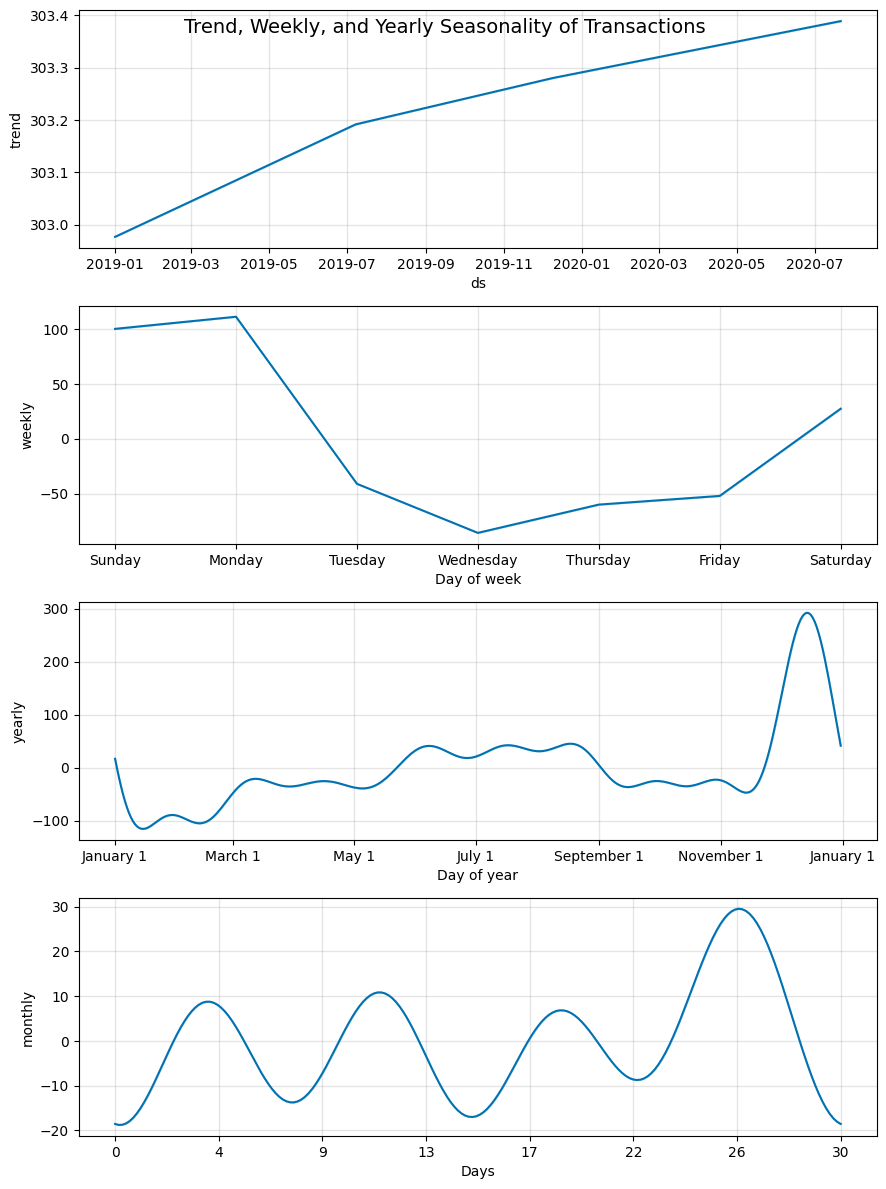

In [ ]:
# Visualize trend, weekly seasonality, and yearly seasonality
fig_components = model.plot_components(forecast)

# Add a main title
fig_components.suptitle("Trend, Weekly, and Yearly Seasonality of Transactions", fontsize=14)

# Save the figure
fig_components.savefig("transaction_components.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


### Anomaly Detection using Prophet Residuals

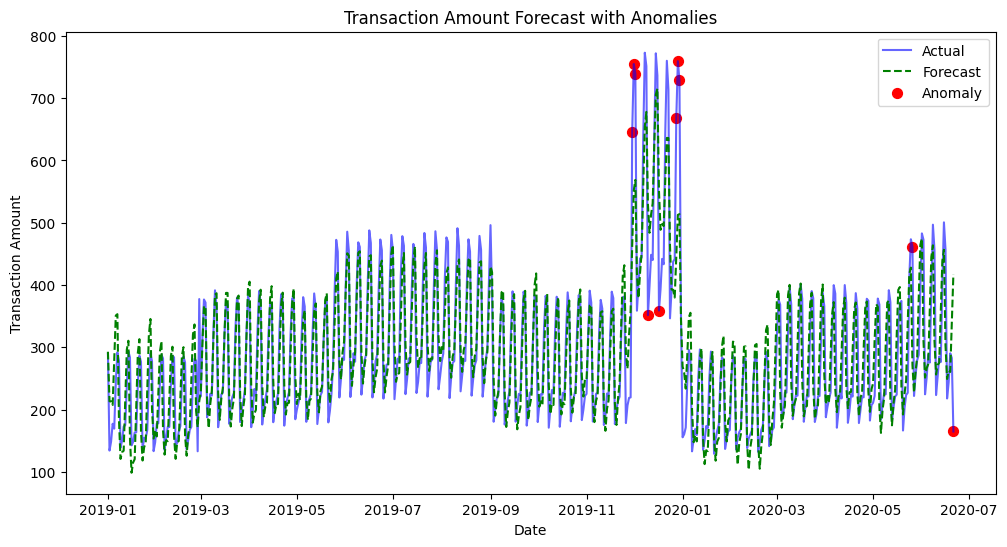

In [ ]:
# ✅ Ensure datetime format matches before merging
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
forecast["ds"] = pd.to_datetime(forecast["ds"])

# ✅ Merge forecasted yhat values
# df_prophet = df_prophet.merge(forecast[["ds", "yhat"]], on="ds", how="left")

# ✅ Compute residuals
df_prophet["residual"] = df_prophet["y"] - df_prophet["yhat"]

# ✅ Define threshold for anomaly detection (3 * std)
threshold = 3 * np.std(df_prophet["residual"])
df_prophet["anomaly"] = np.abs(df_prophet["residual"]) > threshold  # Mark anomalies

# ✅ Plot forecast with anomalies
plt.figure(figsize=(12, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual", color="blue", alpha=0.6)
plt.plot(df_prophet["ds"], df_prophet["yhat"], label="Forecast", color="green", linestyle="dashed")

# ✅ Highlight anomalies
anomalies = df_prophet[df_prophet["anomaly"]]
plt.scatter(anomalies["ds"], anomalies["y"], color="red", label="Anomaly", marker="o", s=50)

# ✅ Add labels and title
plt.xlabel("Date")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount Forecast with Anomalies")
plt.legend()

# ✅ Save & Show the plot
plt.savefig("forecast_anomalies.png", dpi=300, bbox_inches="tight")
plt.show()


### Evaluate Model Performance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df_prophet["y"], df_prophet["yhat"])
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_prophet["y"], df_prophet["yhat"])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R²)
r2 = r2_score(df_prophet["y"], df_prophet["yhat"])
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 37.974252781296386
Mean Squared Error (MSE): 3063.3561143865886
Root Mean Squared Error (RMSE): 55.347593573583566
R-squared (R²): 0.7820931469612191
